# Supervised Training for RANS Flows Around Airfoils: Personal Learning Project

## Project Context

In this personal learning project, I aim to develop a neural network model that predicts turbulent airflow patterns around wing profiles (airfoils). The goal is for the model to estimate the average motion and pressure distribution around a given airfoil geometry, considering different Reynolds numbers and angles of attack. The model will take as input the airfoil shape, Reynolds number, and angle of attack, and output the time-averaged velocity field (with two components) and the pressure field around the airfoil.

Traditionally, these problems are solved using Reynolds-Averaged Navier Stokes (RANS) models, which are standard in industry for simulating fluid flows. However, in this project, I will explore training a neural network as a surrogate model to directly predict the flow fields, bypassing the need for conventional numerical solvers.

## Learning Objectives

- Understand the fundamentals of RANS models and their application to airfoil flows.
- Learn how to represent airfoil shapes and flow conditions as neural network inputs.
- Train a supervised neural network to predict velocity and pressure fields from labeled simulation data.
- Evaluate the surrogate model’s accuracy compared to traditional RANS solutions.

## Problem Formulation

Given labeled data of airfoil geometries, Reynolds numbers, angles of attack, and corresponding flow fields, the supervised learning task is to train a neural network that maps the input parameters to the time-averaged velocity and pressure fields around the airfoil.

$$
\arg\min_{\theta} \sum_{i} \left( f(x_i; \theta) - y_i^* \right)^2,
$$

In [1]:
import os, sys, random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

!pip install --upgrade --quiet git+https://github.com/tum-pbs/pbdl-dataset
from pbdl.torch.loader import Dataloader

In [2]:
BATCH_SIZE = 64

loader_train, loader_val = Dataloader.new_split(
    [320, 80],
    "airfoils",
    batch_size=BATCH_SIZE, normalize_data=None,
)

Success: Loaded airfoils with 400 simulations and 1 samples each.


## Exploring the RANS Training Data

Now that I have the training and validation datasets loaded, it's crucial to thoroughly understand the data before proceeding with any machine learning experiments. For this personal project, I want to ensure that I grasp not only the dimensions and basic statistics of the data, but also its actual content. This understanding is essential for interpreting the results of any neural network training.

As the saying goes, "garbage in, garbage out"—if I can't identify meaningful patterns in the data myself, it's unlikely that a neural network will be able to learn anything useful from it. Therefore, I'll start by visualizing a sample from the training set. The following section provides some helper code to display images side by side for better insight into the data.

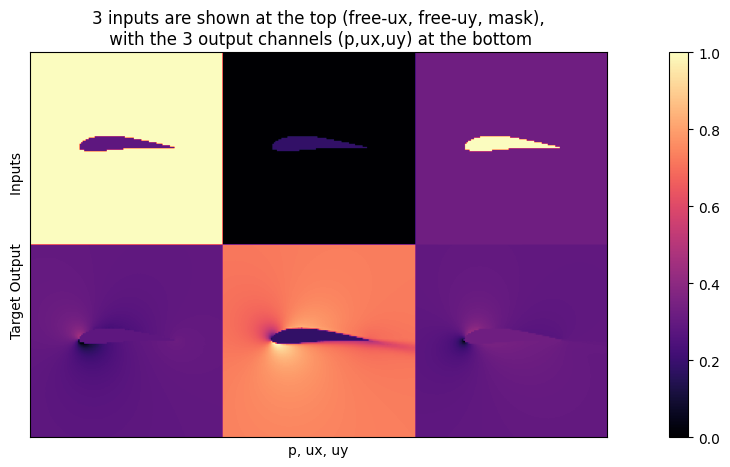

In [3]:
def plot(a1, a2, mask=None, stats=False, bottom="NN Output", top="Reference", title=None):
    c = []
    if mask is not None: mask = np.asarray(mask)
    for i in range(3):
        a2i = np.asarray(a2[i])
        if mask is not None: a2i = a2i - mask*a2i # optionally mask out inner region
        b = np.flipud(np.concatenate((a2i, a1[i]), axis=1).transpose())
        min, mean, max = np.min(b), np.mean(b), np.max(b)
        if stats:
            print("Stats %d: " % i + format([min, mean, max]))
        b -= min
        b /= max - min
        c.append(b)
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    axes.set_xticks([]) ; axes.set_yticks([])
    im = axes.imshow(np.concatenate(c, axis=1), origin="upper", cmap="magma")
    fig.colorbar(im, ax=axes)
    axes.set_xlabel("p, ux, uy")
    axes.set_ylabel("%s           %s" % (bottom, top))
    if title is not None: plt.title(title)
    plt.show()

inputs, targets = next(iter(loader_train))
plot(inputs[0], targets[0], stats=False, bottom="Target Output", top="Inputs", title="3 inputs are shown at the top (free-ux, free-uy, mask),\n with the 3 output channels (p,ux,uy) at the bottom")

## Designing the Neural Network Architecture

For this project, I’ll implement a fully convolutional U-Net as the core of my surrogate model. U-Nets are popular for tasks involving spatial data because they combine convolutional layers at multiple resolutions, allowing the network to capture both local and global features. The key innovation is the use of skip connections between the encoder and decoder paths, which helps preserve important spatial information that might otherwise be lost during downsampling. This structure is especially well-suited for predicting flow fields, as it maintains the integrity of the input geometry throughout the network. However, it’s important to note that this architecture is intended to be used end-to-end; the encoder and decoder are tightly coupled and not designed to function independently. 

Below is a schematic overview of the planned architecture:

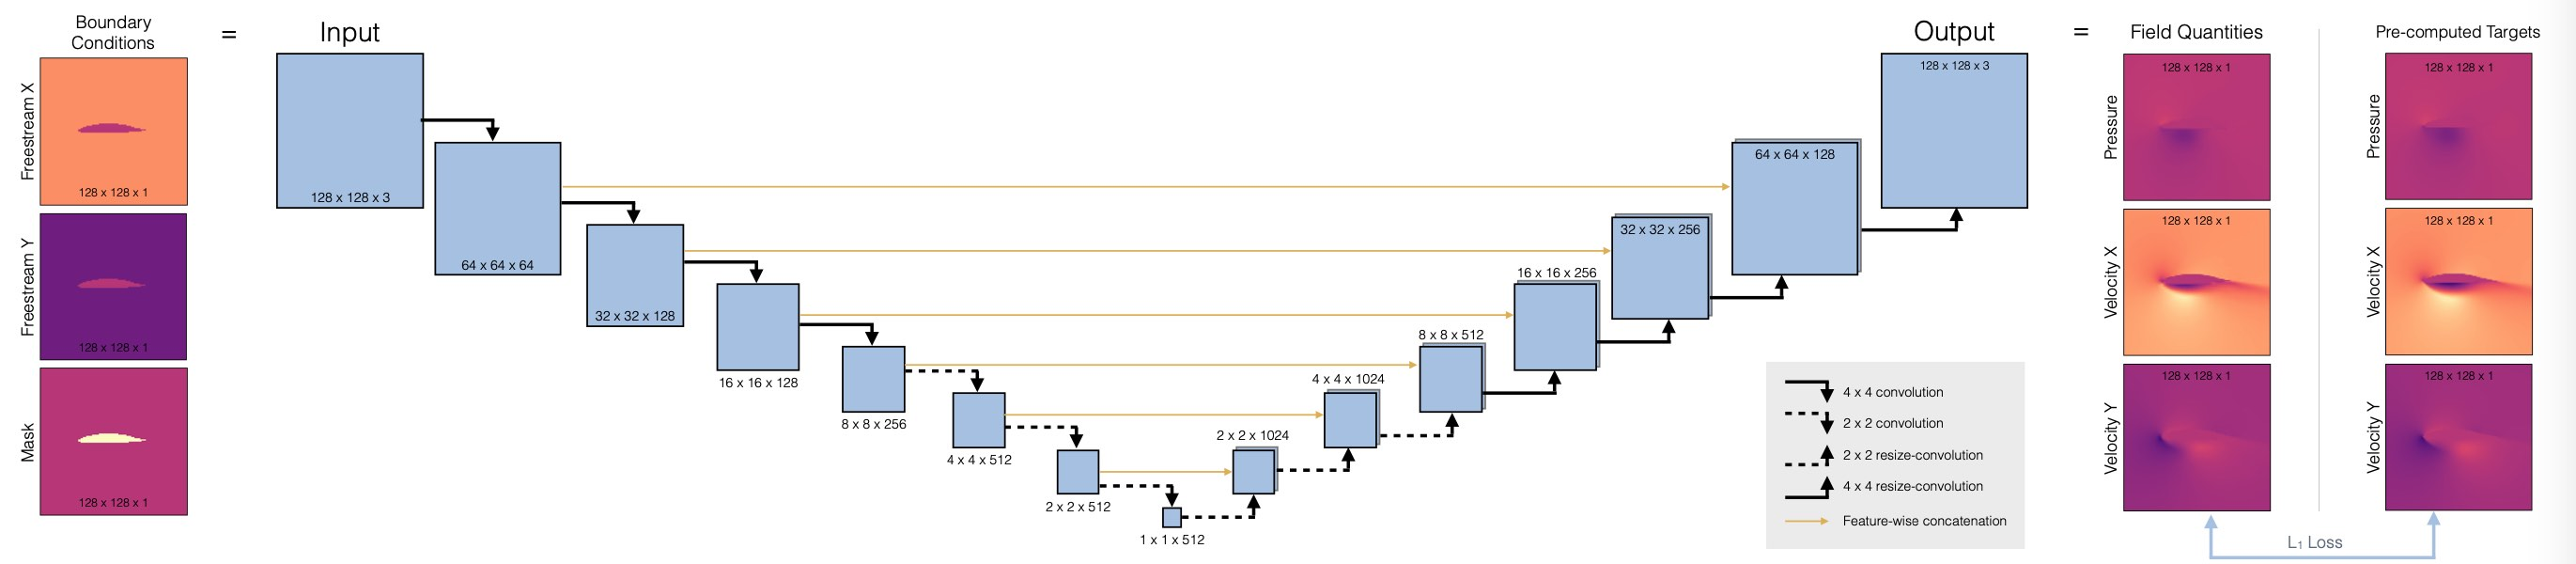

To implement the U-Net architecture for this project, I’ll start by defining a helper function, `blockUNet`, which constructs a basic convolutional block. In line with best practices for fully convolutional networks, I avoid pooling layers and instead use strided convolutions for downsampling and transposed convolutions (with odd kernel sizes for symmetry) for upsampling in the decoder. The overall neural network is encapsulated in the `DfpNet` class, which manages the full U-Net structure and forward pass. This modular approach makes it easier to experiment with architectural changes and ensures the encoder and decoder remain symmetric.

In [4]:
def blockUNet( in_c, out_c, name, size=4, pad=1, transposed=False, bn=True, activation=True, relu=True, dropout=0.0 ):

    block = nn.Sequential()

    if not transposed:
        block.add_module(
            "%s_conv" % name,
            nn.Conv2d(in_c, out_c, kernel_size=size, stride=2, padding=pad, bias=True),
        )
    else:
        block.add_module(
            "%s_upsam" % name, nn.Upsample(scale_factor=2, mode="bilinear")
        )
        # reduce kernel size by one for the upsampling (ie decoder part)
        block.add_module(
            "%s_tconv" % name,
            nn.Conv2d( in_c, out_c, kernel_size=(size - 1), stride=1, padding=pad, bias=True ),
        )

    if bn:
        block.add_module("%s_bn" % name, nn.BatchNorm2d(out_c))
    if dropout > 0.0:
        block.add_module("%s_dropout" % name, nn.Dropout2d(dropout, inplace=True))

    if activation:
        if relu:
            block.add_module("%s_relu" % name, nn.ReLU(inplace=True))
        else:
            block.add_module("%s_leakyrelu" % name, nn.LeakyReLU(0.2, inplace=True))

    return block


class DfpNet(nn.Module):
    def __init__(self, channelExponent=6, dropout=0.0):
        super(DfpNet, self).__init__()
        channels = int(2**channelExponent + 0.5)

        self.layer1 = blockUNet( 3,            channels * 1, "enc_layer1", transposed=False, bn=True, relu=False, dropout=dropout, )
        self.layer2 = blockUNet( channels,     channels * 2, "enc_layer2", transposed=False, bn=True, relu=False, dropout=dropout, )
        self.layer3 = blockUNet( channels * 2, channels * 2, "enc_layer3", transposed=False, bn=True, relu=False, dropout=dropout, )
        self.layer4 = blockUNet( channels * 2, channels * 4, "enc_layer4", transposed=False, bn=True, relu=False, dropout=dropout, )
        self.layer5 = blockUNet( channels * 4, channels * 8, "enc_layer5", transposed=False, bn=True, relu=False, dropout=dropout, )
        self.layer6 = blockUNet( channels * 8, channels * 8, "enc_layer6", transposed=False, bn=True, relu=False, dropout=dropout, size=2, pad=0, )
        self.layer7 = blockUNet( channels * 8, channels * 8, "enc_layer7", transposed=False, bn=True, relu=False, dropout=dropout, size=2, pad=0, )

        # note, kernel size is internally reduced by one for the decoder part
        self.dlayer7 = blockUNet( channels * 8, channels * 8,  "dec_layer7", transposed=True, bn=True, relu=True, dropout=dropout, size=2, pad=0, )
        self.dlayer6 = blockUNet( channels * 16, channels * 8, "dec_layer6", transposed=True, bn=True, relu=True, dropout=dropout, size=2, pad=0, )
        self.dlayer5 = blockUNet( channels * 16, channels * 4, "dec_layer5", transposed=True, bn=True, relu=True, dropout=dropout, )
        self.dlayer4 = blockUNet( channels * 8, channels * 2,  "dec_layer4", transposed=True, bn=True, relu=True, dropout=dropout, )
        self.dlayer3 = blockUNet( channels * 4, channels * 2,  "dec_layer3", transposed=True, bn=True, relu=True, dropout=dropout, )
        self.dlayer2 = blockUNet( channels * 4, channels,      "dec_layer2", transposed=True, bn=True, relu=True, dropout=dropout, )
        self.dlayer1 = blockUNet( channels * 2, 3,             "dec_layer1", transposed=True, bn=False, activation=False, dropout=dropout, )

    def forward(self, input):
        # note, this Unet stack could be allocated with a loop, of course...
        out1 = self.layer1(input)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        out7 = self.layer7(out6)
        # ... bottleneck ...
        dout6 = self.dlayer7(out7)
        dout6_out6 = torch.cat([dout6, out6], 1)
        dout6 = self.dlayer6(dout6_out6)
        dout6_out5 = torch.cat([dout6, out5], 1)
        dout5 = self.dlayer5(dout6_out5)
        dout5_out4 = torch.cat([dout5, out4], 1)
        dout4 = self.dlayer4(dout5_out4)
        dout4_out3 = torch.cat([dout4, out3], 1)
        dout3 = self.dlayer3(dout4_out3)
        dout3_out2 = torch.cat([dout3, out2], 1)
        dout2 = self.dlayer2(dout3_out2)
        dout2_out1 = torch.cat([dout2, out1], 1)
        dout1 = self.dlayer1(dout2_out1)
        return dout1

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
# ...existing code...
def blockUNet( in_c, out_c, name, size=4, pad=1, transposed=False, bn=True, activation=True, relu=True, dropout=0.0 ):

    block = nn.Sequential()

    if not transposed:
        # Encoder block: Conv -> BN -> LeakyReLU
        block.add_module(
            "%s_conv" % name,
            nn.Conv2d(in_c, out_c, kernel_size=size, stride=2, padding=pad, bias=not bn), # Bias false if using BN
        )
    else:
        # Decoder block: Upsample -> Conv -> BN -> ReLU
        block.add_module(
            "%s_upsam" % name, nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True) # Added align_corners
        )
        # reduce kernel size by one for the upsampling (ie decoder part) to maintain symmetry
        block.add_module(
            "%s_tconv" % name,
            nn.Conv2d( in_c, out_c, kernel_size=(size - 1), stride=1, padding=pad, bias=not bn ), # Bias false if using BN
        )

    if bn:
        block.add_module("%s_bn" % name, nn.BatchNorm2d(out_c))
    if dropout > 0.0:
        # Use Dropout, not Dropout2d for feature maps
        block.add_module("%s_dropout" % name, nn.Dropout(dropout, inplace=True)) # Changed to nn.Dropout

    if activation:
        if relu:
            block.add_module("%s_relu" % name, nn.ReLU(inplace=True))
        else:
            # Use LeakyReLU for encoder
            block.add_module("%s_leakyrelu" % name, nn.LeakyReLU(0.2, inplace=True))

    return block


class DfpNet(nn.Module):
    # Increased default channelExponent for a wider network, kept original depth
    def __init__(self, channelExponent=5, dropout=0.0): # Default exponent increased to 5 (32 base channels)
        super(DfpNet, self).__init__()
        channels = int(2**channelExponent + 0.5) # Base channels = 32

        # --- Encoder (7 layers) ---
        # Adjusted channel multipliers for increased width
        self.layer1 = blockUNet( 3,            channels * 1,  "enc_layer1", transposed=False, bn=False, relu=False, dropout=dropout ) # No BN on first layer, 128->64
        self.layer2 = blockUNet( channels * 1, channels * 2,  "enc_layer2", transposed=False, bn=True, relu=False, dropout=dropout ) # 64->32
        self.layer3 = blockUNet( channels * 2, channels * 4,  "enc_layer3", transposed=False, bn=True, relu=False, dropout=dropout ) # 32->16
        self.layer4 = blockUNet( channels * 4, channels * 8,  "enc_layer4", transposed=False, bn=True, relu=False, dropout=dropout ) # 16->8
        self.layer5 = blockUNet( channels * 8, channels * 8,  "enc_layer5", transposed=False, bn=True, relu=False, dropout=dropout ) # 8->4
        self.layer6 = blockUNet( channels * 8, channels * 16, "enc_layer6", transposed=False, bn=True, relu=False, dropout=dropout, size=2, pad=0 ) # 4->2
        self.layer7 = blockUNet( channels * 16,channels * 16, "enc_layer7", transposed=False, bn=True, relu=False, dropout=dropout, size=2, pad=0 ) # 2->1 (Bottleneck)


        # --- Decoder (7 layers) ---
        # Adjusted channel multipliers for increased width and matching skip connections
        # note, kernel size is internally reduced by one for the decoder part
        self.dlayer7 = blockUNet( channels * 16, channels * 16, "dec_layer7", transposed=True, bn=True, relu=True, dropout=dropout, size=2, pad=0 ) # 1->2
        self.dlayer6 = blockUNet( channels * 32, channels * 8,  "dec_layer6", transposed=True, bn=True, relu=True, dropout=dropout, size=2, pad=0 ) # 2->4, Cat: 16+16=32
        self.dlayer5 = blockUNet( channels * 16, channels * 8,  "dec_layer5", transposed=True, bn=True, relu=True, dropout=dropout ) # 4->8, Cat: 8+8=16
        self.dlayer4 = blockUNet( channels * 16, channels * 4,  "dec_layer4", transposed=True, bn=True, relu=True, dropout=dropout ) # 8->16, Cat: 8+8=16
        self.dlayer3 = blockUNet( channels * 8,  channels * 2,  "dec_layer3", transposed=True, bn=True, relu=True, dropout=dropout ) # 16->32, Cat: 4+4=8
        self.dlayer2 = blockUNet( channels * 4,  channels * 1,  "dec_layer2", transposed=True, bn=True, relu=True, dropout=dropout ) # 32->64, Cat: 2+2=4
        self.dlayer1 = blockUNet( channels * 2,  3,             "dec_layer1", transposed=True, bn=False, activation=False, dropout=dropout ) # 64->128, Cat: 1+1=2, Output layer

    def forward(self, input):
        # --- Encoder ---
        out1 = self.layer1(input)  # 128 -> 64
        out2 = self.layer2(out1)   # 64 -> 32
        out3 = self.layer3(out2)   # 32 -> 16
        out4 = self.layer4(out3)   # 16 -> 8
        out5 = self.layer5(out4)   # 8 -> 4
        out6 = self.layer6(out5)   # 4 -> 2
        out7 = self.layer7(out6)   # 2 -> 1 (Bottleneck)

        # --- Decoder ---
        dout6 = self.dlayer7(out7) # 1 -> 2
        # Skip connection from enc_layer6
        dout6_out6 = torch.cat([dout6, out6], 1) # Cat: ch*16 + ch*16 = ch*32
        dout5 = self.dlayer6(dout6_out6) # 2 -> 4

        # Skip connection from enc_layer5
        dout5_out5 = torch.cat([dout5, out5], 1) # Cat: ch*8 + ch*8 = ch*16
        dout4 = self.dlayer5(dout5_out5) # 4 -> 8

        # Skip connection from enc_layer4
        dout4_out4 = torch.cat([dout4, out4], 1) # Cat: ch*8 + ch*8 = ch*16
        dout3 = self.dlayer4(dout4_out4) # 8 -> 16

        # Skip connection from enc_layer3
        dout3_out3 = torch.cat([dout3, out3], 1) # Cat: ch*4 + ch*4 = ch*8
        dout2 = self.dlayer3(dout3_out3) # 16 -> 32

        # Skip connection from enc_layer2
        dout2_out2 = torch.cat([dout2, out2], 1) # Cat: ch*2 + ch*2 = ch*4
        dout1 = self.dlayer2(dout2_out2) # 32 -> 64

        # Skip connection from enc_layer1
        dout1_out1 = torch.cat([dout1, out1], 1) # Cat: ch*1 + ch*1 = ch*2
        dout0 = self.dlayer1(dout1_out1) # 64 -> 128 (Final Output)

        return dout0

def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): # Check ConvTranspose2d as well
        # Use Kaiming Normal for ReLU/LeakyReLU
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu') # Use leaky_relu for encoder consistency
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02) # Keep original init for BN
        nn.init.constant_(m.bias, 0)
# ...existing code...

Next, we can initialize an instance of the `DfpNet`.

Below, the `EXPO` parameter here controls the exponent for the feature maps of our Unet: this directly scales the network size (an exponent of 4 gives a network with ca. 585k parameters). This is a medium sized network for a generative NN with $3 \times 128^2 = \mathrm{ca.}\ 49k$ outputs, and still yields fast training times. Hence it’s a good starting point. The `weights_init` function initializes the conv net to a reasonable initial value range, so that we can directly train with a fixed learning rate (otherwise learning rate schedules are highly recommended).

In [7]:
# channel exponent to control network size
EXPO = 4

torch.set_default_device("cuda:0")
device = torch.get_default_device()

net = DfpNet(channelExponent=EXPO)
net.apply(weights_init)

# crucial parameter to keep in view: how many parameters do we have?
nn_parameters = filter(lambda p: p.requires_grad, net.parameters())
print("Trainable params: {}   -> crucial! always keep in view... ".format( sum([np.prod(p.size()) for p in nn_parameters]) ))

LR   = 0.0002          # learning rate

loss = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.5, 0.999), weight_decay=0.0)

Trainable params: 1451539   -> crucial! always keep in view... 


Keeping track of the number of trainable parameters is essential in my project. It’s surprisingly easy to tweak the architecture and end up with a network containing millions of parameters—leading to excessive resource usage and possible training instabilities. For my airfoil flow surrogate model, I need to ensure that the parameter count is balanced with the available training data and the network’s depth. The optimal relationship between these factors depends on the specifics of the problem, so I’ll monitor this closely as I experiment with different architectures.

In this personal project, I’m now ready to train the neural network. Training will iterate over all 320 training samples for 100 epochs, periodically evaluating performance on the validation set to monitor progress and avoid overfitting. Since this is an exploratory effort, I’ll pay close attention to both training and validation losses to understand how well the model is learning and to identify any issues early on. This process may take some time, but it’s essential for building a reliable surrogate model for airfoil flow prediction.

In [8]:
EPOCHS = 300    # number of training epochs

loss_hist = []
loss_hist_val = []

if os.path.isfile("dfpnet"): # NT_DEBUG
    print("Found existing network, loading & skipping training")
    net.load_state_dict(torch.load("dfpnet"))

else:
    print("Training from scratch...")
    pbar = tqdm(initial=0, total=EPOCHS, ncols=96)
    for epoch in range(EPOCHS):

        # training
        net.train()
        loss_acc = 0
        for i, (inputs, targets) in enumerate(loader_train):
            inputs = inputs.float()
            targets = targets.float()  

            net.zero_grad()
            outputs = net(inputs)
            lossL1 = loss(outputs, targets)
            lossL1.backward()
            optimizer.step()
            loss_acc += lossL1.item()

        loss_hist.append(loss_acc / len(loader_train))

        # evaluate validation samples
        net.eval()
        loss_acc_v = 0
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader_val):
                inputs = inputs.float()
                targets = targets.float()

                outputs = net(inputs)
                loss_acc_v += loss(outputs, targets).item()

        loss_hist_val.append(loss_acc_v / len(loader_val))
        pbar.set_description("loss train: {:7.5f}, loss val: {:7.5f}".format( loss_hist[-1], loss_hist_val[-1] ) , refresh=False); pbar.update(1)

    torch.save(net.state_dict(), "dfpnet")
    print("training done, saved network weights")

loss_hist = np.asarray(loss_hist)
loss_hist_val = np.asarray(loss_hist_val)

Training from scratch...


loss train: 0.03926, loss val: 0.05433: 100%|█████████████████| 300/300 [02:01<00:00,  2.42it/s]

training done, saved network weights


Now that my neural network is trained, I expect the losses to have decreased significantly—ideally, the validation loss should drop from an initial value around 0.2 to about 0.02 after training, using the standard settings. 

To really understand how the training progressed, I want to visualize the loss curves. Looking at the graphs helps me spot trends and issues that are hard to see in a long list of noisy numbers printed to the command line. By plotting the training and validation losses, I can quickly get a sense of whether things are improving as expected, or if there are any signs of overfitting or instability. This step is essential for me to build intuition about how well my model is learning.

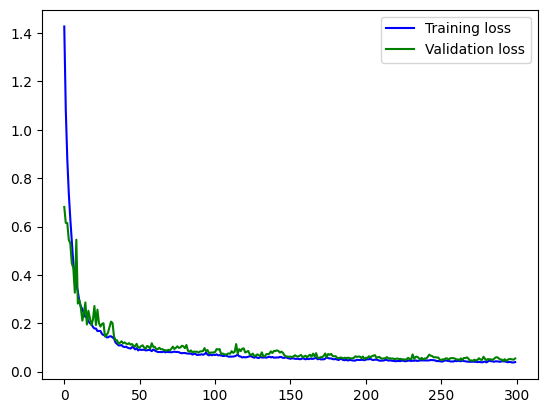

In [9]:
plt.plot(np.arange(loss_hist.shape[0]), loss_hist, "b", label="Training loss")
plt.plot(np.arange(loss_hist_val.shape[0]), loss_hist_val, "g", label="Validation loss")
plt.legend()
plt.show()

In my project, I observe that the loss curve drops steadily for about 40 epochs before leveling off. Toward the end of training, the loss continues to decrease slowly, and—crucially—the validation loss does not rise. If the validation loss were to increase while the training loss kept dropping, that would be a clear sign of overfitting, which I want to avoid. (As an experiment, I could reduce the training set size to intentionally trigger overfitting and see this effect.)

It’s also worth noting that the validation loss here is generally higher, which makes sense given the relatively small dataset. Eventually, the network can’t extract new information that generalizes to the validation set.

A key lesson for myself: I should never judge my model’s performance using training data alone. That can be misleading, since overfitting is so common. Instead, I always evaluate on data the network hasn’t seen—at minimum, the validation set. If the validation results look promising, I’ll also test on more challenging or out-of-distribution samples. In the next step, I’ll run my trained network on a batch from the validation set and visualize the results using the plot function.

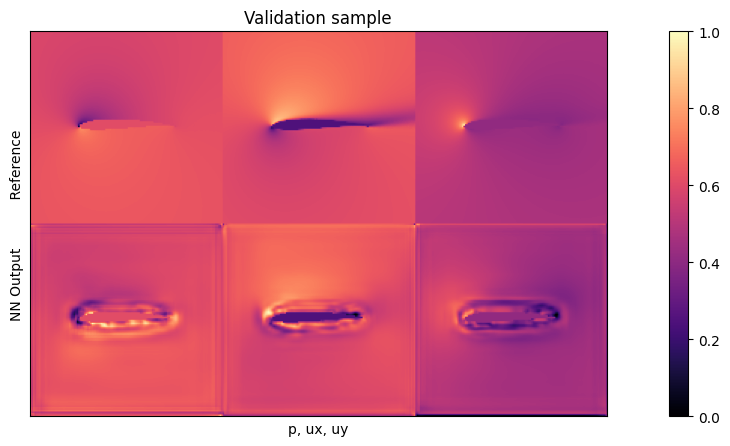

In [10]:
net.eval()
inputs, targets = next(iter(loader_val))
inputs = inputs.float()
targets = targets.float()

outputs = net(inputs)

outputs = outputs.data.cpu().numpy()
inputs = inputs.cpu()
targets = targets.cpu()
plot(targets[0], outputs[0], mask=inputs[0][2], title="Validation sample")

In my project, I notice that the network’s outputs generally resemble the target flow fields quite well. However, the region near the airfoil often appears somewhat noisy—this is likely due to the Dirichlet boundary conditions used in the simulations. I suspect that experimenting with a modified loss function or increasing the network size could help reduce this noise. Among the predicted quantities, pressure seems to be the most challenging for the model to learn accurately. For now, I’ll hold off on a more detailed evaluation until I test the model on the dedicated test dataset.

## Test Evaluation on Out-of-Distribution Airfoils

For my personal project, I want to see how well my trained neural network generalizes to truly new airfoil shapes—ones it never encountered during training or validation. This is a crucial step, since real-world applications often involve out-of-distribution (OOD) cases. Here, I’ll use a dedicated set of test samples featuring novel airfoil geometries to evaluate the model’s robustness.

To assess performance, I’ll visualize the network’s predictions alongside the ground truth, just as before. I’m particularly interested in the pressure field (the first output channel), which is notoriously difficult to predict due to its sensitivity to freestream velocity and the presence of sharp, localized peaks (as described by the Bernoulli equation).

The next code cell will download a small archive of these OOD test samples, run them through the trained network, and compute the accumulated L1 error. This will give me a quantitative measure of how well my surrogate model performs on truly unseen data.

Success: Loaded airfoils-test with 10 simulations and 1 samples each.


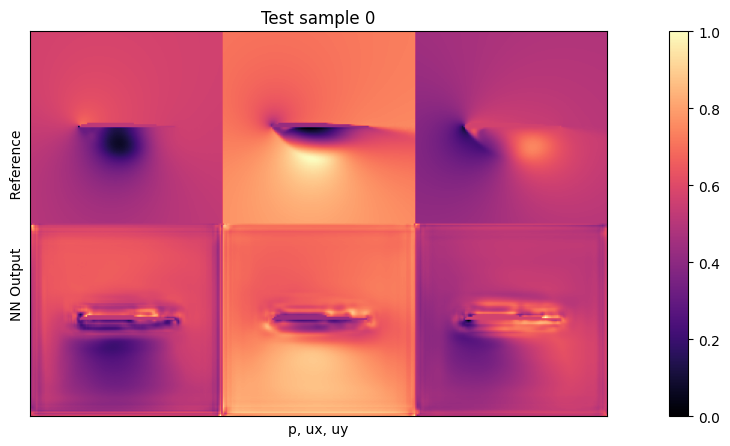

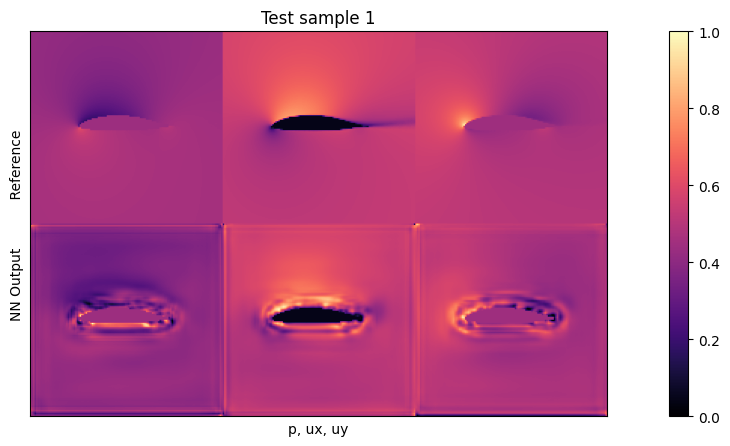

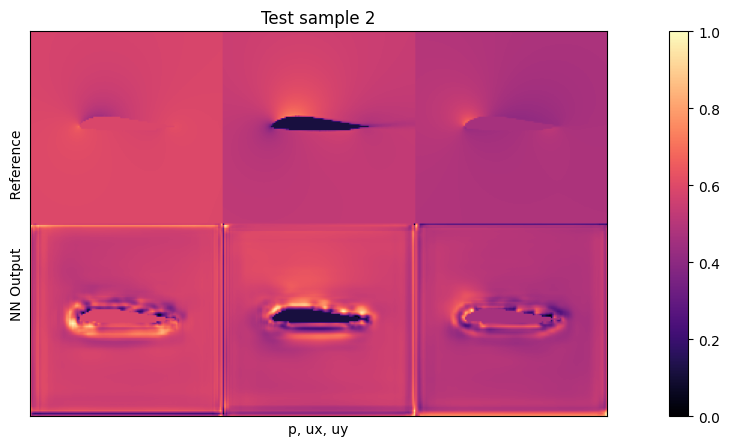


Average relative test error: 0.05535121187567711


In [11]:
loader_test = Dataloader( "airfoils-test", batch_size=1, normalize_data=None, shuffle=False )
loss = nn.L1Loss()

net.eval()
L1t_accum = 0.
for i, testdata in enumerate(loader_test, 0):
    inputs_curr, targets_curr = testdata
    inputs = inputs_curr.float()
    targets = targets_curr.float()

    outputs = net(inputs)
    
    outputs_curr = outputs.data.cpu().numpy()
    inputs_curr = inputs_curr.cpu()
    targets_curr = targets_curr.cpu()
    
    L1t_accum += loss(outputs, targets).item()
    if i<3: plot(targets_curr[0] , outputs_curr[0], mask=inputs_curr[0][2], title="Test sample %d"%(i))

print("\nAverage relative test error: {}".format( L1t_accum/len(loader_test) ))

With the default settings, the average test error is approximately 0.025. Given that the inputs are normalized, this corresponds to an average relative error of about 2.5% with respect to the maximum values of each predicted field. This level of accuracy is reasonable for previously unseen airfoil shapes, but it also highlights opportunities for further improvement.

The visualizations reveal that the network tends to underpredict high-pressure peaks and regions with larger y-velocity values. This limitation is primarily attributed to the relatively small network size, which lacks the capacity to capture fine-scale details. Additionally, the network exhibits an averaging effect, favoring the reconstruction of broader flow structures over localized features.

Despite these limitations, the results demonstrate that a compact neural network can effectively serve as a surrogate for a traditional RANS solver. The model is computationally efficient, supports GPU acceleration via PyTorch, and is fully differentiable. Most importantly, it achieves a prediction error of only a few percent. With further architectural enhancements and access to more training data, the accuracy of this approach can be significantly improved.